#  Series de tiempo

El análisis de series de tiempo se suele utilizar para proyectar o pronosticar la evolución de una variable a lo largo del tiempo, a partir de información previa sobre esa misma variable. Es decir, tenemos que proyectar (plotear) una variable determinada (eje y) en función del tiempo (eje x). 

En este caso, nuestra variable de interés el el precio de la cebolla en India, en el dataset contamos con información desagregada por ciudad. En principio, realizaremos un análisis exploratorio para observar su evolución temporal (1) y, luego, pronosticaremos el precio para los próximos periodos de tiempo con una serie de modelos básicos (2) y con otros más avanzados (3), incluyendo el modelo ARIMA.


## 1) Analisis exploratorio y preprocessing

El dataset tiene tres columnas (features o variables) son sobre la ubicación del mercado mayorista donde se vendió cebolla:

* **state**: Esta es la abreviatura de 2/3 letras para el estado en India (PB es Punjab, etc.)
* **ciudad**: Esta es la ciudad en India (ABOHAR, BANGALORE y así sucesivamente)
* **mercado**: esta es una cadena con la combinación del estado y la ciudad

Tres están relacionados con la fecha de la transacción: 
* **mes**: mes en enero, febrero y así sucesivamente.
* **año**: año en YYYY representatión
* **fecha**: la combinación de los dos anteriores.

Cuatro son acerca de la cantidad y el precio en este mercado mayorista (todas numéricas).
* **cantidad**: La cantidad de cebolla que llega al mercado en ese mes en quintales (100 kg)
* **priceMin**: el precio mínimo en el mes en Rs./quintal
* **priceMax**: el precio máximo en el mes en Rs./quintal
* **priceMod**: el precio modal en el mes en Rs./quintal

### Generalizando, identificamos distintas ESTRUCTURAS DE DATOS...
* **CATEGORICA**: estado, ciudad, mercado
* **INTERVALO DE TIEMPO**: mes, año, fecha
* **CUANTITATIVA**: cantidad, precioMin, priceMax, priceModal


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import statsmodel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

In [2]:

df = pd.read_csv("onion_price_I.csv")
df.shape

(11682, 10)

In [3]:
df.tail()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
11677,YEOLA(MS),December,2012,207066,485,1327,1136,MH,YEOLA,December-2012
11678,YEOLA(MS),December,2013,215883,472,1427,1177,MH,YEOLA,December-2013
11679,YEOLA(MS),December,2014,201077,446,1654,1456,MH,YEOLA,December-2014
11680,YEOLA(MS),December,2015,223315,609,1446,1126,MH,YEOLA,December-2015
11681,YEOLA(MS),December,2016,214937,256,753,634,MH,YEOLA,December-2016


In [4]:
df.dtypes

market      object
month       object
year         int64
quantity     int64
priceMin     int64
priceMax     int64
priceMod     int64
state       object
city        object
date        object
dtype: object

In [5]:
# Cambiamos el formado de la columna 'date'
df.date = pd.DatetimeIndex(df.date)
df['date'].dtype
# es equivalente a datetime64

dtype('<M8[ns]')

In [6]:
# Podemos reindexar nuestro dataframe 
df = df.sort_values(by = "date")
df.index = pd.PeriodIndex(df.date, freq='M')
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
date,,,,,,,,,,
1996-01,LASALGAON(MS),January,1996,225063,160,257,226,MH,LASALGAON,1996-01-01
1996-02,LASALGAON(MS),February,1996,196164,133,229,186,MH,LASALGAON,1996-02-01
1996-03,LASALGAON(MS),March,1996,178992,155,274,243,MH,LASALGAON,1996-03-01
1996-04,LASALGAON(MS),April,1996,192592,136,279,254,MH,LASALGAON,1996-04-01
1996-05,LASALGAON(MS),May,1996,237574,154,312,269,MH,LASALGAON,1996-05-01


In [7]:
len(pd.unique(df.year)), pd.unique(df.year)

(22,
 array([1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
        2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
       dtype=int64))

In [8]:
len(pd.unique(df.city)), pd.unique(df.city)

(177,
 array(['LASALGAON', 'PIMPALGAON', 'NIPHAD', 'SAIKHEDA', 'SINNAR',
        'MANMAD', 'CHAKAN', 'LONAND', 'BHAVNAGAR', 'MAHUVA', 'PUNE',
        'AHMEDNAGAR', 'HUBLI', 'DHULIA', 'DEWAS', 'RAHURI', 'GONDAL',
        'DINDIGUL', 'NASIK', 'INDORE', 'DHAVANGERE', 'BOMBORI', 'HASSAN',
        'RAJKOT', 'KARNAL', 'DELHI', 'MANDSOUR', 'SURAT', 'KOLKATA',
        'PATNA', 'HYDERABAD', 'CHICKBALLAPUR', 'MALEGAON', 'CHENNAI',
        'SOLAPUR', 'KANPUR', 'JAIPUR', 'LUCKNOW', 'KALVAN', 'SHIMLA',
        'MUMBAI', 'NAGPUR', 'KOLHAPUR', 'YEOLA', 'KOLAR', 'SRINAGAR',
        'BANGALORE', 'BELGAUM', 'KURNOOL', 'SANGAMNER', 'SANGALI',
        'GUWAHATI', 'JUNNAR', 'JODHPUR', 'JAMMU', 'JALGAON', 'JALANDHAR',
        'RANCHI', 'MADURAI', 'SATANA', 'ABOHAR', 'AHMEDABAD', 'UJJAIN',
        'BIJAPUR', 'TRIVENDRUM', 'AGRA', 'BHUBNESWER', 'BHOPAL',
        'AMRITSAR', 'VARANASI', 'SHRIRAMPUR', 'BHATINDA', 'DEVALA',
        'PATIALA', 'LUDHIANA', 'RAIPUR', 'VANI', 'DINDORI', 'UDAIPUR',
        'ALWAR', '

El precio en cada una de estas ciudades conforma una serie de tiempo. Vamos a 
ver cuál de estas ciudades tuvo mayor volumen de ventas y vamos a recortar nuestro análisis a esa ciudad.

In [9]:
df.groupby('city')['quantity'].sum().sort_values(ascending=False).head()

city
BANGALORE     85065826
PUNE          62527507
LASALGAON     61695792
PIMPALGAON    56691321
DELHI         49049635
Name: quantity, dtype: int64

Nos quedamos entonces con la serie de tiempo de la ciudad de Bangalore

In [10]:
dfBang = df[df.city == 'BANGALORE'].copy()
dfBang.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
date,,,,,,,,,,
2004-01,BANGALORE,January,2004,227832,916,1066,991,KT,BANGALORE,2004-01-01
2004-02,BANGALORE,February,2004,225133,741,870,793,KT,BANGALORE,2004-02-01
2004-03,BANGALORE,March,2004,221952,527,586,556,KT,BANGALORE,2004-03-01
2004-04,BANGALORE,April,2004,185150,419,518,465,KT,BANGALORE,2004-04-01
2004-05,BANGALORE,May,2004,137390,400,516,455,KT,BANGALORE,2004-05-01


Grafiquemos ahora el precio mínimo, el máximo y la moda para cada mes. 

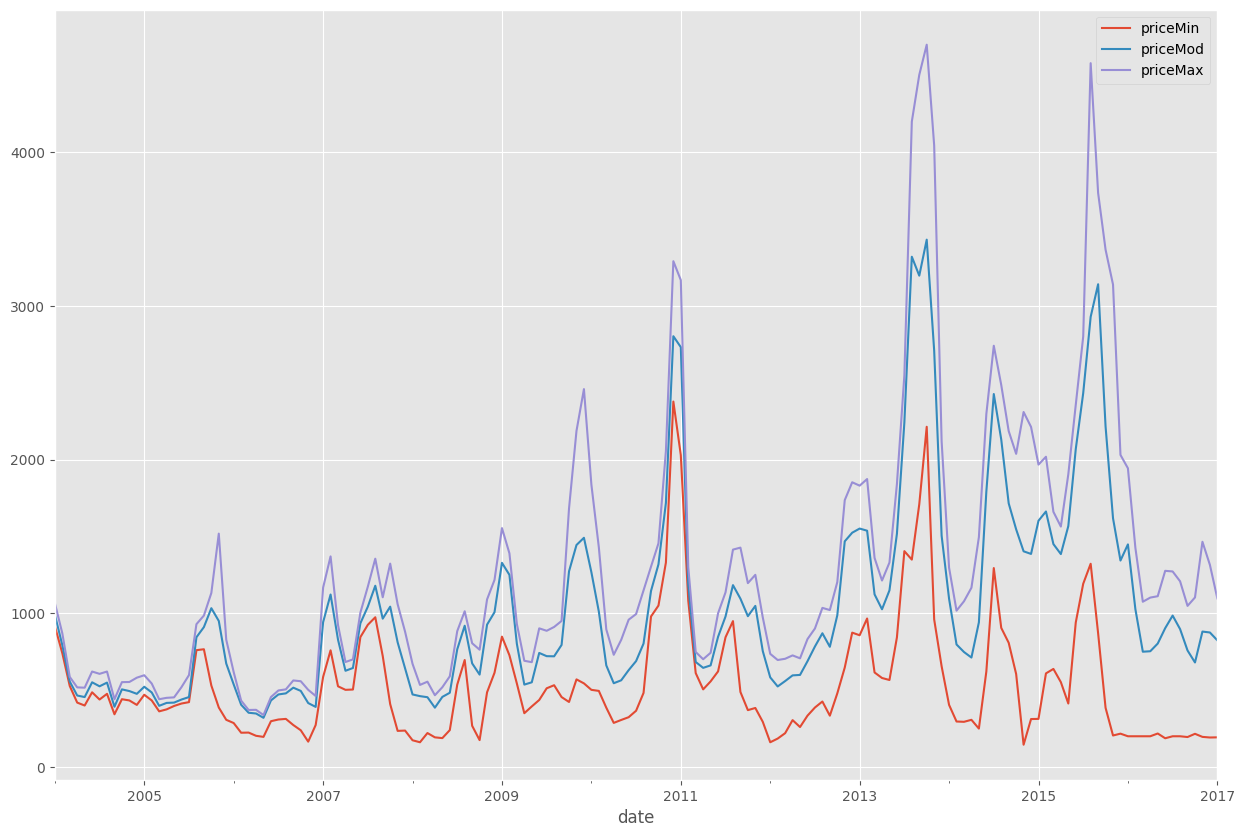

In [11]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 10)
dfBang.plot(kind = "line", y = ['priceMin', 'priceMod', 'priceMax']);

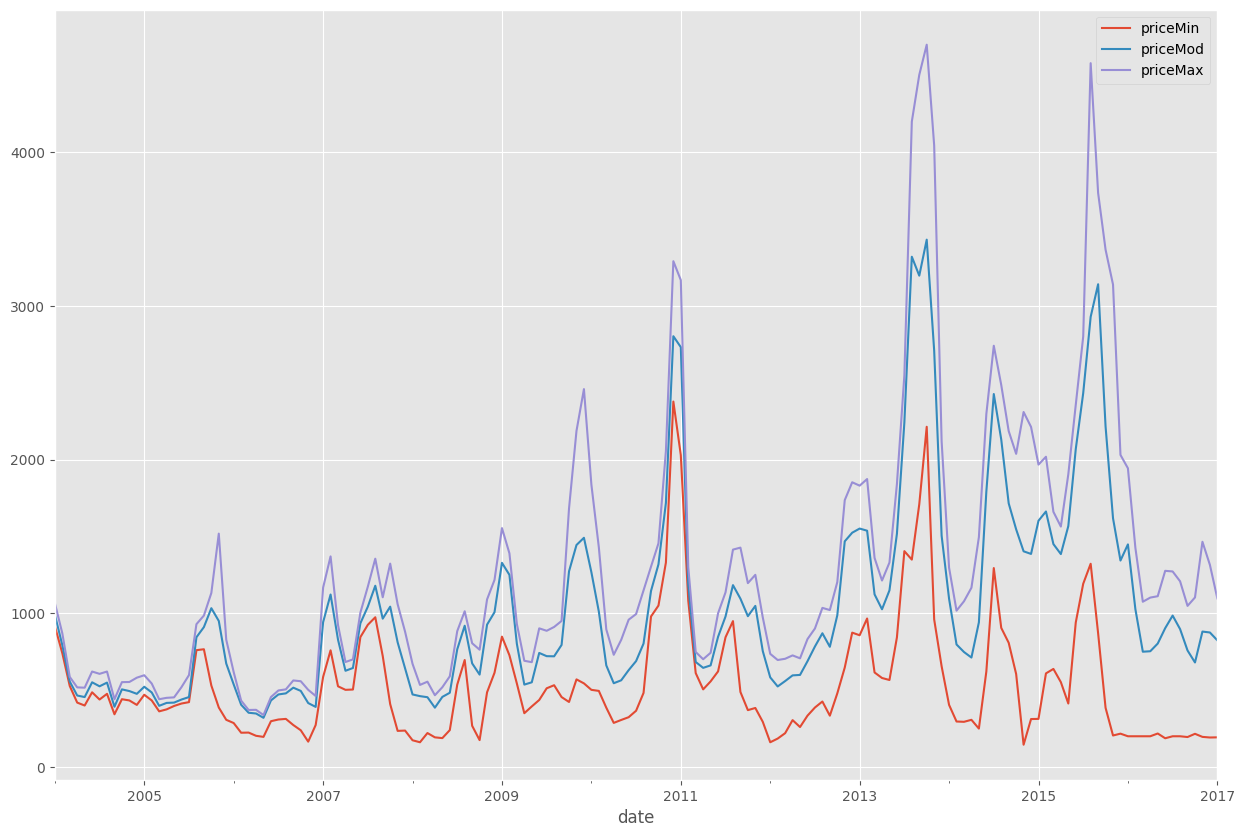

In [12]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 10)
dfBang.plot(kind = "line", y = ['priceMin', 'priceMod', 'priceMax']);

Veamos lo que pasa si aplicamos una transformación logarítmica a la serie:

In [13]:
# Transformamos a logaritmo para reducir la variablidad de la serie
dfBang['priceModLog'] = np.log(dfBang.priceMod)
dfBang.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,priceModLog
date,,,,,,,,,,,
2004-01,BANGALORE,January,2004,227832,916,1066,991,KT,BANGALORE,2004-01-01,6.898715
2004-02,BANGALORE,February,2004,225133,741,870,793,KT,BANGALORE,2004-02-01,6.675823
2004-03,BANGALORE,March,2004,221952,527,586,556,KT,BANGALORE,2004-03-01,6.320768
2004-04,BANGALORE,April,2004,185150,419,518,465,KT,BANGALORE,2004-04-01,6.142037
2004-05,BANGALORE,May,2004,137390,400,516,455,KT,BANGALORE,2004-05-01,6.120297


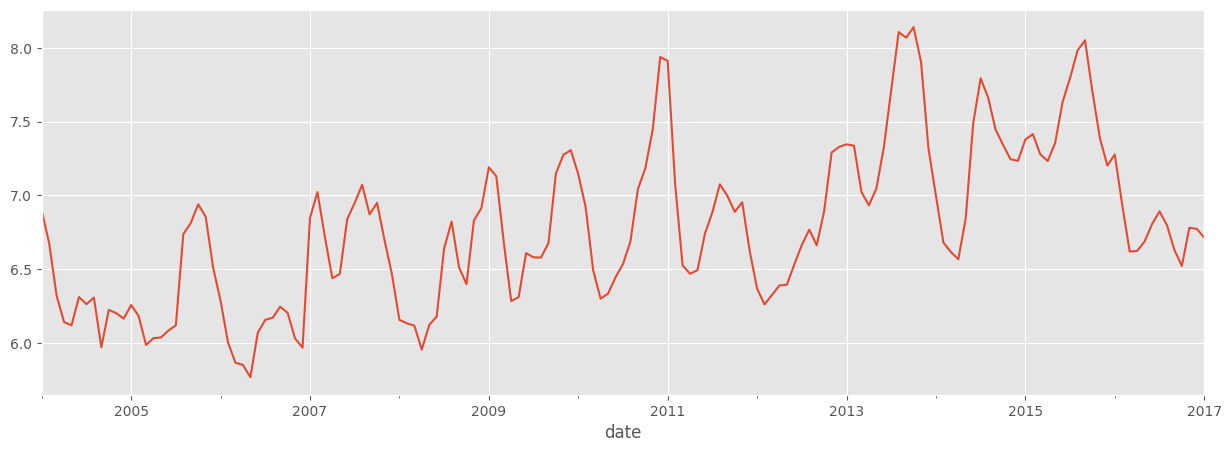

In [14]:
plt.rcParams['figure.figsize'] = (15, 5)
dfBang.priceModLog.plot();

Como la transformación logaritmo no es lineal, observamos que las fluctuaciones son más parecidas entre sí al principio y al final de la serie. 

## 2) Modelos básicos para prónosticos
* Modelo de la media constante
* Modelo de tendencia lineal
* Modelo Random Walk


La serie que vamos a intentar predecir con los siguientes modelos es la moda del precio mensual de la cebolla en el mercado de Bangalore. 

## 2.a) Media constante

In [15]:
# Calculamos el promedio, uniforme para todos
model_mean_pred = dfBang.priceModLog.mean()

# Transformamos ese volor, inicialmente calculado en logaritmo
# Lo asignamos a una columna
dfBang["priceMean"] = np.exp(model_mean_pred)

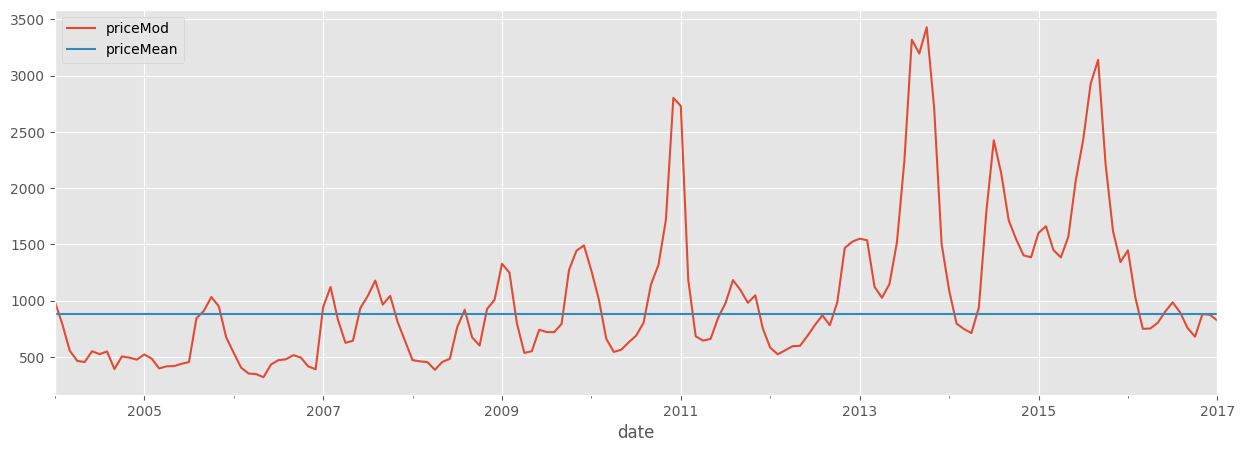

In [16]:
# Ploteamos los valores originales
dfBang.plot(kind="line", x="date", y = ["priceMod", "priceMean"]);

* ¿Cuán bien ajusta esta estimación?

Calculemos el Error Cuadrático Medio y su raíz...

In [17]:
def RMSE(predicted, actual):
    mse = (predicted - actual)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

In [18]:
model_mean_RMSE = RMSE(dfBang.priceMean, dfBang.priceMod)
model_mean_RMSE

661.0403243978387

In [19]:
# Guardamos todo en un dataframe
dfBangResults = pd.DataFrame(columns = ["Model", "Forecast", "RMSE"])
dfBangResults.loc[0,"Model"] = "Mean"
dfBangResults.loc[0,"Forecast"] = np.exp(model_mean_pred)
dfBangResults.loc[0,"RMSE"] = model_mean_RMSE
dfBangResults.head()

,Model,Forecast,RMSE
0,Mean,879.77008,661.040324


* ¿Cómo interpretás este resultado?

## 2.b) Tendencia lineal

Continuaremos trabajando con la tendencia lineal entre priceModLog y time. Primero tenemos que crear un  indicador numérico para el período de tiempo para hacer una regresión lineal.

In [20]:
# Rotomamos el subset de Bangalore
# Identificamos el punto de inicio de la data
dfBang.date.min()

Timestamp('2004-01-01 00:00:00')

In [21]:
# Convertimos nuestra data almacenada en 'date' en datetime-delta, comenzando por cero
dfBang["timeIndex"] = dfBang.date - dfBang.date.min()
dfBang.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,priceModLog,priceMean,timeIndex
date,,,,,,,,,,,,,
2004-01,BANGALORE,January,2004,227832,916,1066,991,KT,BANGALORE,2004-01-01,6.898715,879.77008,0 days
2004-02,BANGALORE,February,2004,225133,741,870,793,KT,BANGALORE,2004-02-01,6.675823,879.77008,31 days
2004-03,BANGALORE,March,2004,221952,527,586,556,KT,BANGALORE,2004-03-01,6.320768,879.77008,60 days
2004-04,BANGALORE,April,2004,185150,419,518,465,KT,BANGALORE,2004-04-01,6.142037,879.77008,91 days
2004-05,BANGALORE,May,2004,137390,400,516,455,KT,BANGALORE,2004-05-01,6.120297,879.77008,121 days


In [22]:
dfBang.columns

Index(['market', 'month', 'year', 'quantity', 'priceMin', 'priceMax',
       'priceMod', 'state', 'city', 'date', 'priceModLog', 'priceMean',
       'timeIndex'],
      dtype='object')

In [23]:
# Transformamos la última columna de días a meses con timedelta
dfBang["timeIndex"] =  (dfBang["timeIndex"]/ np.timedelta64(1, 'D') / 30.44)
dfBang.timeIndex.head()

date
2004-01    0.000000
2004-02    1.018397
2004-03    1.971091
2004-04    2.989488
2004-05    3.975033
Freq: M, Name: timeIndex, dtype: float64

In [24]:
# Redondeamos, quitando todos los decimales
dfBang["timeIndex"] = dfBang["timeIndex"].round(0).astype(int)
dfBang.timeIndex.tail()

date
2016-09    152
2016-10    153
2016-11    154
2016-12    155
2017-01    156
Freq: M, Name: timeIndex, dtype: int32

In [25]:
dfBang.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,priceModLog,priceMean,timeIndex
date,,,,,,,,,,,,,
2004-01,BANGALORE,January,2004,227832,916,1066,991,KT,BANGALORE,2004-01-01,6.898715,879.77008,0
2004-02,BANGALORE,February,2004,225133,741,870,793,KT,BANGALORE,2004-02-01,6.675823,879.77008,1
2004-03,BANGALORE,March,2004,221952,527,586,556,KT,BANGALORE,2004-03-01,6.320768,879.77008,2
2004-04,BANGALORE,April,2004,185150,419,518,465,KT,BANGALORE,2004-04-01,6.142037,879.77008,3
2004-05,BANGALORE,May,2004,137390,400,516,455,KT,BANGALORE,2004-05-01,6.120297,879.77008,4


In [26]:
# Ahora fiteamos nuestro modelo de regresión lineal entre priceMod y timeIndex
model_linear = smf.ols('priceModLog ~ timeIndex', data = dfBang).fit()

El primer argumento corresponde a la forma funcional de nuestra estimación. [Más detalles](http://www.statsmodels.org/dev/examples/notebooks/generated/formulas.html).

In [27]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            priceModLog   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     93.00
Date:                Wed, 26 Feb 2025   Prob (F-statistic):           1.57e-17
Time:                        13:58:37   Log-Likelihood:                -88.669
No. Observations:                 157   AIC:                             181.3
Df Residuals:                     155   BIC:                             187.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.2122      0.068     91.289      0.000       6.078       6.347
timeIndex      0.0073      0.001      9.644      0.000       0.006       0.009
==============================================================================
Omnibus:                        6.193   Durbin-Watson:                   0.321
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                6.235
Skew:                           0.454   Prob(JB):                       0.0443
Kurtosis:                       2.642   Cond. No.                         180.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
model_linear_pred = model_linear.predict()
model_linear_pred[:5]

array([6.21223835, 6.21951299, 6.22678764, 6.23406228, 6.24133692])

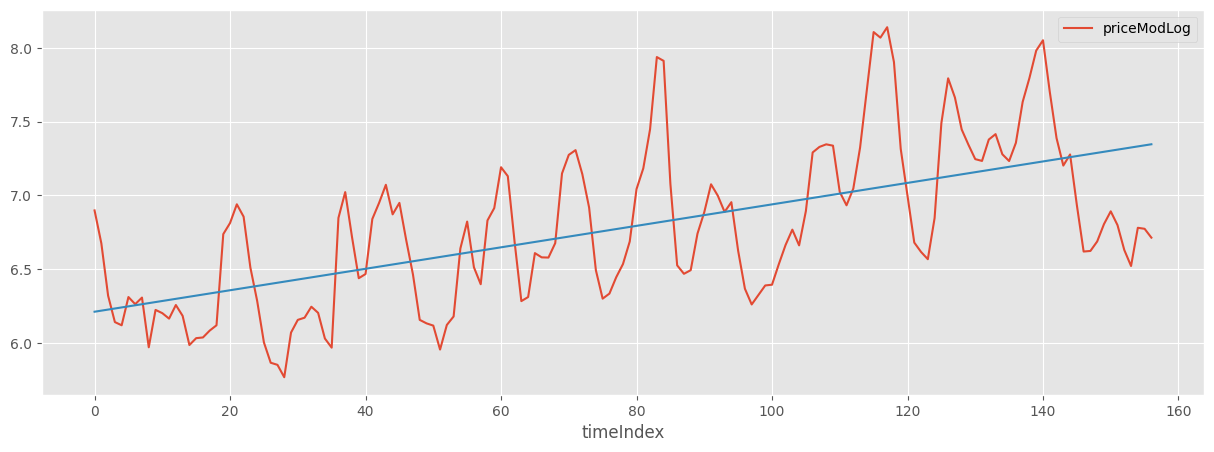

In [29]:
# Ploteamos los resultados de la predicción
dfBang.plot(kind="line", x="timeIndex", y = "priceModLog")
plt.plot(dfBang.timeIndex,model_linear_pred, '-');

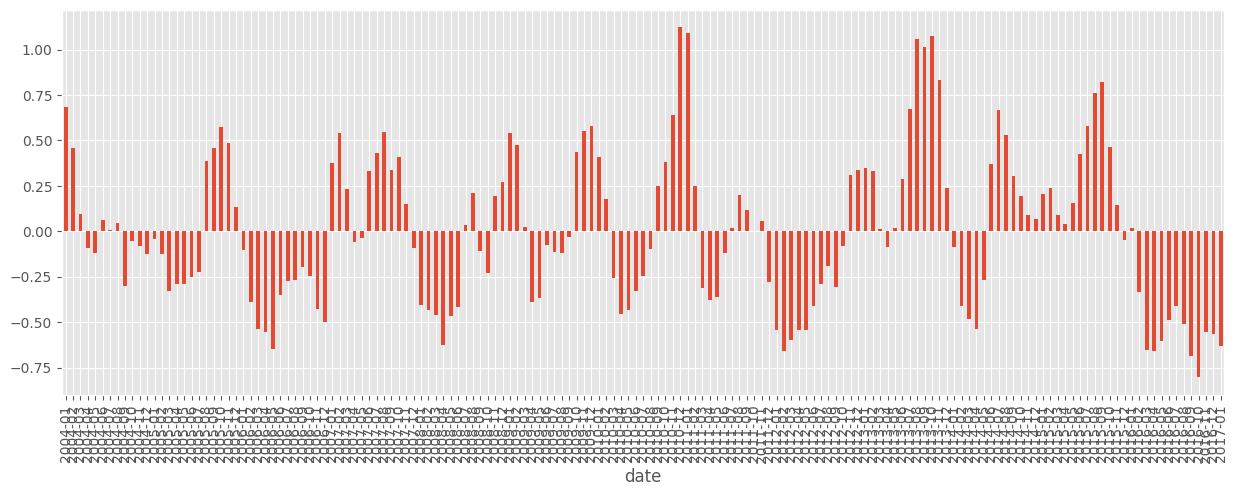

In [30]:
# Ploteamos los residuos de nuestra estimación
model_linear.resid.plot(kind = "bar");

* ¿Tenemos un mejor modelo respecto de la media constante? ¿Cómo podemos verificarlo?

En ambos gráficos vemos que el modelo de tendencia lineal es propenso a cometer un error del mismo signo durante varios períodos seguidos. Este sesgo del modelo se mide en términos estadísticos mediante la **autocorrelación lag-1** (se denomina así a la correlación de una variable respecto a sí misma rezagada un período de tiempo) a través del estadístico **Durbin-Watson**. Si no hay un patrón de tiempo, la autocorrelación lag-1 debería ser muy cercana a cero (veamos el cuadro resumen del modelo más arriba) y, por lo tanto, la estadística de Durbin-Watson debería ser  muy cercana a 2 (no es este caso). Si el modelo ha logrado extraer toda la "señal" de los datos, no debería haber ningún patrón en los errores, es decir, el error del período siguiente no debería estar correlacionado con ningún error anterior como observamos aquí. El modelo de tendencia lineal suele fallar cuando se testea la autocorrelación.

In [31]:
dfBang["priceLinear"] = np.exp(model_linear_pred)
dfBang.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,priceModLog,priceMean,timeIndex,priceLinear
date,,,,,,,,,,,,,,
2004-01,BANGALORE,January,2004,227832,916,1066,991,KT,BANGALORE,2004-01-01,6.898715,879.77008,0,498.816527
2004-02,BANGALORE,February,2004,225133,741,870,793,KT,BANGALORE,2004-02-01,6.675823,879.77008,1,502.458471
2004-03,BANGALORE,March,2004,221952,527,586,556,KT,BANGALORE,2004-03-01,6.320768,879.77008,2,506.127005
2004-04,BANGALORE,April,2004,185150,419,518,465,KT,BANGALORE,2004-04-01,6.142037,879.77008,3,509.822324
2004-05,BANGALORE,May,2004,137390,400,516,455,KT,BANGALORE,2004-05-01,6.120297,879.77008,4,513.544622


In [32]:
# Root Mean Squared Error (RMSE)
model_linear_RMSE = RMSE(dfBang.priceLinear, dfBang.priceMod)
model_linear_RMSE

564.9981129612853

In [33]:
# Añadimos estos datos a nuestro DF de resultados para comparar con el modelo anterior
dfBangResults.loc[1,"Model"] = "Linear"
dfBangResults.loc[1,"Forecast"] = np.exp(model_linear_pred)
dfBangResults.loc[1,"RMSE"] = model_linear_RMSE
dfBangResults.head()

,Model,Forecast,RMSE
0,Mean,879.77008,661.040324
1,Linear,"[498.8165271009785, 502.458470759112, 506.1270...",564.998113


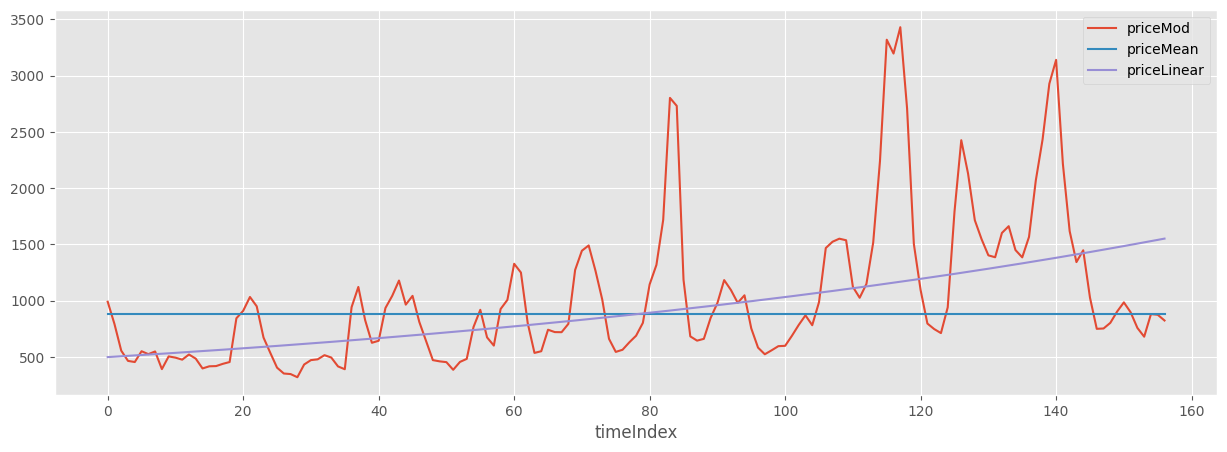

In [34]:
# Ploteamos las dos estimaciones
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", "priceLinear"]);

### Tendencia lineal con un regresor

Ahora vamos a explorar un modelo lineal que permite tener en cuenta la cantidad.
Cuando incluimos un feature adicional (además del tiempo) en una serie de tiempo existen dos posibilidades:
1. El regresor se conoce a la hora de pronosticar: por ejemplo la ubicación donde la empresa estará en un momento del tiempo, que ya puede estar planificada.
2. El regresor no se conoce a la hora de pronosticar: por ejemplo la cantidad en este caso

Cuando nos encontramos en el segundo escenario, tenemos que tener en cuenta que el modelo de serie de tiempo va a ser útil para entender las relaciones entre las variables recurriendo al pasado (es decir, para modelar) pero no para hacer pronósticos a futuro.


In [35]:
# Ahora estimamos una variante del modelo lineal, incluyendo el logaritmo de las cantidades como regresor
model_linear_quantity = smf.ols('priceModLog ~ timeIndex + np.log(quantity)', data = dfBang).fit()
model_linear_quantity.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            priceModLog   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     49.61
Date:                Wed, 26 Feb 2025   Prob (F-statistic):           2.35e-17
Time:                        13:58:38   Log-Likelihood:                -86.527
No. Observations:                 157   AIC:                             179.1
Df Residuals:                     154   BIC:                             188.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.3537      0.903      4.821      0.000       2.570       6.138
timeIndex            0.0065      0.001      7.735      0.000       0.005       0.008
np.log(quantity)     0.1471      0.071      2.064      0.041       0.006       0.288
==============================================================================
Omnibus:                        5.380   Durbin-Watson:                   0.343
Prob(Omnibus):                  0.068   Jarque-Bera (JB):                5.323
Skew:                           0.410   Prob(JB):                       0.0699
Kurtosis:                       2.626   Cond. No.                     2.43e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
dfBang["priceLinearQuantity"] = np.exp(model_linear_quantity.predict())

In [37]:
model_linear_quantity.params

Intercept           4.353660
timeIndex           0.006486
np.log(quantity)    0.147076
dtype: float64

In [38]:
# Calculamos el RMSE y lo añadimos al DF de resultados
dfBangResults.loc[2,"Model"] = "LinearQuantity"
dfBangResults.loc[2,"Forecast"] = np.exp(model_linear_quantity.params[0] + 
                                        model_linear_quantity.params[1] * 146 +
                                        model_linear_quantity.params[2] * np.log(4000000))
dfBangResults.loc[2,"RMSE"] = RMSE(dfBang.priceLinearQuantity, dfBang.priceMod)
dfBangResults.head()

C:\Users\yporq\AppData\Local\Temp\ipykernel_59976\1604113122.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dfBangResults.loc[2,"Forecast"] = np.exp(model_linear_quantity.params[0] +
C:\Users\yporq\AppData\Local\Temp\ipykernel_59976\1604113122.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model_linear_quantity.params[1] * 146 +
C:\Users\yporq\AppData\Local\Temp\ipykernel_59976\1604113122.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use 

,Model,Forecast,RMSE
0,Mean,879.77008,661.040324
1,Linear,"[498.8165271009785, 502.458470759112, 506.1270...",564.998113
2,LinearQuantity,1875.237553,555.419677


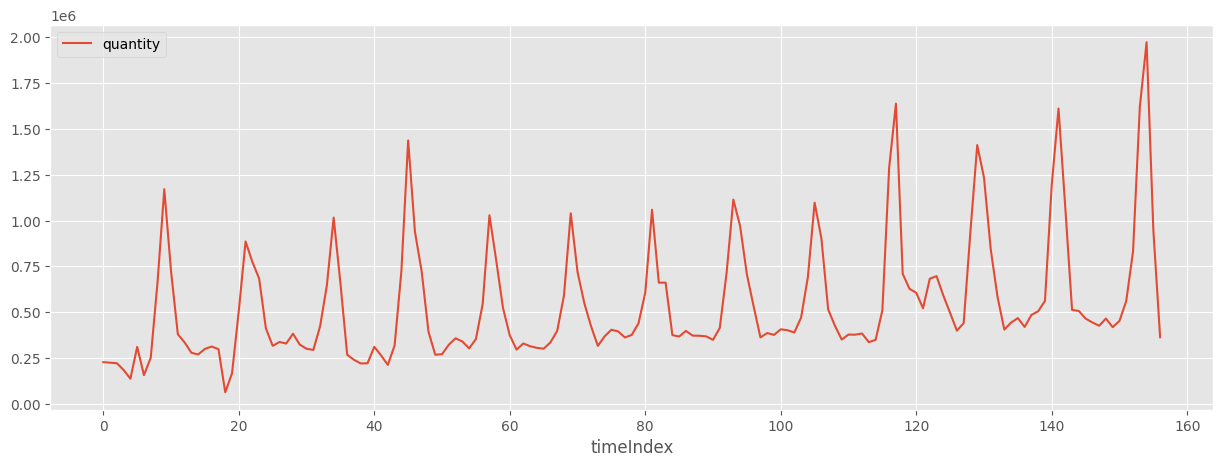

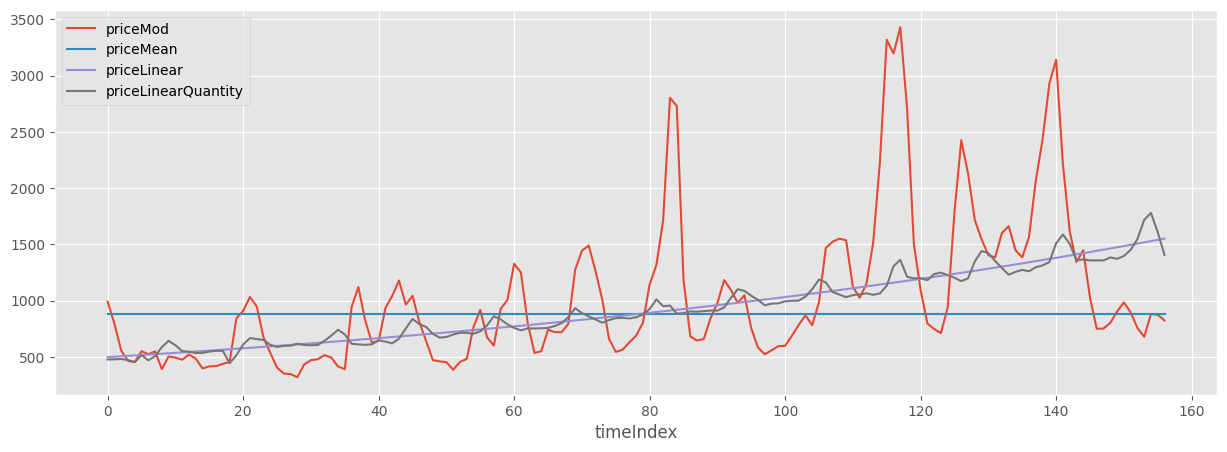

In [39]:
dfBang.plot(kind = "line", x="timeIndex", y = "quantity")
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", 
                                             "priceLinear", "priceLinearQuantity"]);

Obsrvamos que al usar la cantidad para modelar el precio el modelo puede dar mejor cuenta de las fluctuaciones.

## 2.c) Random Walk

Cuando nos enfrentamos a una serie de tiempo que muestra crecimiento irregular, la mejor estrategia no es tratar de predecir directamente el nivel de la serie en cada período (es decir, el valor Yt), sino el cambio que ocurre de un período al siguiente (es decir, la diferencia Yt - Yt-1). Se observa la primera diferencia (o lag) de la serie para encontrar un patrón predecible. 

A los efectos del pronóstico del próximo período, puede ser tan bueno predecir el nivel como la variación, ya que el cambio predicho puede agregarse al nivel actual para generar un nivel pronosticado. El caso más simple de dicho modelo es uno que siempre predice que el siguiente cambio será cero, como si la serie tuviera la misma probabilidad de subir o bajar en el próximo período, independientemente de lo que haya sucedido en el pasado.

**Random Walk** $$ \ hat {Y_t} = Y_ {t-1} + \ epsilon \\ $$

**Random Walk with drift (derivada)** $$ \ hat {Y_t} = Y_ {t-1} + c + \ epsilon \\ $$

In [40]:
# Generamos el desplazamiento de nuestro nuestro target (lag=1)
dfBang["priceModLogShift1"] = dfBang.priceModLog.shift()
dfBang.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,priceModLog,priceMean,timeIndex,priceLinear,priceLinearQuantity,priceModLogShift1
date,,,,,,,,,,,,,,,,
2004-01,BANGALORE,January,2004,227832,916,1066,991,KT,BANGALORE,2004-01-01,6.898715,879.77008,0,498.816527,477.253620,NaN
2004-02,BANGALORE,February,2004,225133,741,870,793,KT,BANGALORE,2004-02-01,6.675823,879.77008,1,502.458471,479.518099,6.898715
2004-03,BANGALORE,March,2004,221952,527,586,556,KT,BANGALORE,2004-03-01,6.320768,879.77008,2,506.127005,481.629448,6.675823
2004-04,BANGALORE,April,2004,185150,419,518,465,KT,BANGALORE,2004-04-01,6.142037,879.77008,3,509.822324,472.008583,6.320768
2004-05,BANGALORE,May,2004,137390,400,516,455,KT,BANGALORE,2004-05-01,6.120297,879.77008,4,513.544622,454.684748,6.142037


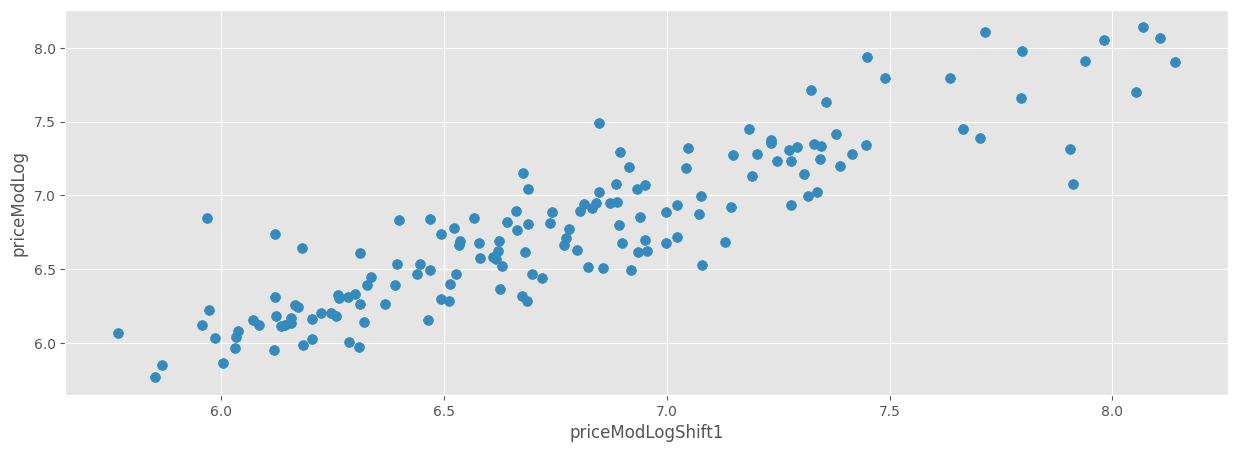

In [41]:
dfBang.plot(kind= "scatter", y = "priceModLog", x = "priceModLogShift1", s = 50);

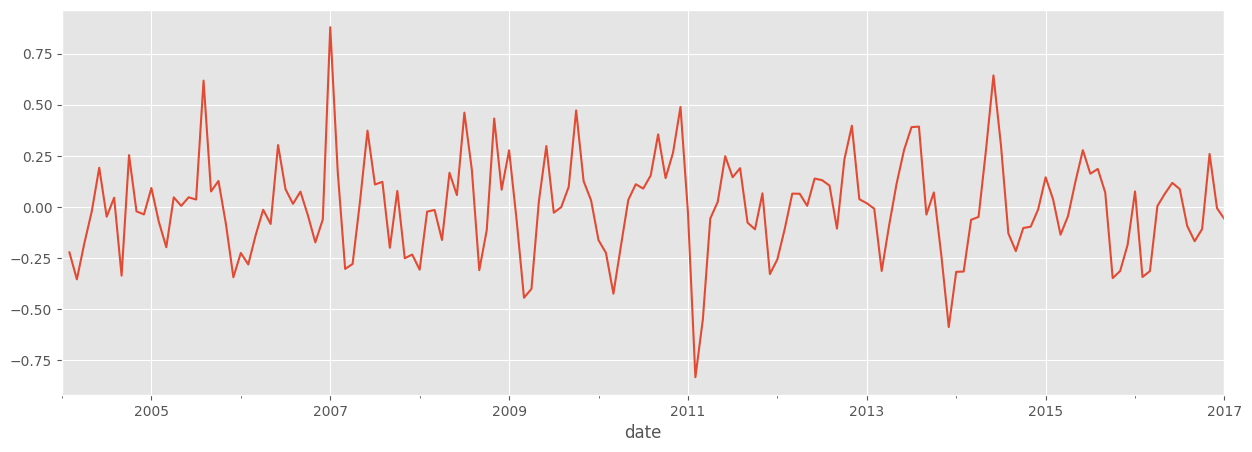

In [42]:
# Ploteamos la relación entre nuestro target y el lag de un período
dfBang["priceModLogDiff"] = dfBang.priceModLog - dfBang.priceModLogShift1
dfBang.priceModLogDiff.plot();

In [43]:
dfBang["priceRandom"] = np.exp(dfBang.priceModLogShift1)
dfBang.tail()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,priceModLog,priceMean,timeIndex,priceLinear,priceLinearQuantity,priceModLogShift1,priceModLogDiff,priceRandom
date,,,,,,,,,,,,,,,,,,
2016-09,BANGALORE,September,2016,831895,195,1048,758,KT,BANGALORE,2016-09-01,6.630683,879.77008,152,1507.162884,1547.580604,6.799056,-0.168372,897.0
2016-10,BANGALORE,October,2016,1620273,216,1103,680,KT,BANGALORE,2016-10-01,6.522093,879.77008,153,1518.166935,1718.113199,6.630683,-0.108591,758.0
2016-11,BANGALORE,November,2016,1974018,196,1465,881,KT,BANGALORE,2016-11-01,6.781058,879.77008,154,1529.251328,1780.255979,6.522093,0.258965,680.0
2016-12,BANGALORE,December,2016,947081,192,1315,875,KT,BANGALORE,2016-12-01,6.774224,879.77008,155,1540.416650,1608.375119,6.781058,-0.006834,881.0
2017-01,BANGALORE,January,2017,363991,193,1097,824,KT,BANGALORE,2017-01-01,6.714171,879.77008,156,1551.663492,1406.449037,6.774224,-0.060053,875.0


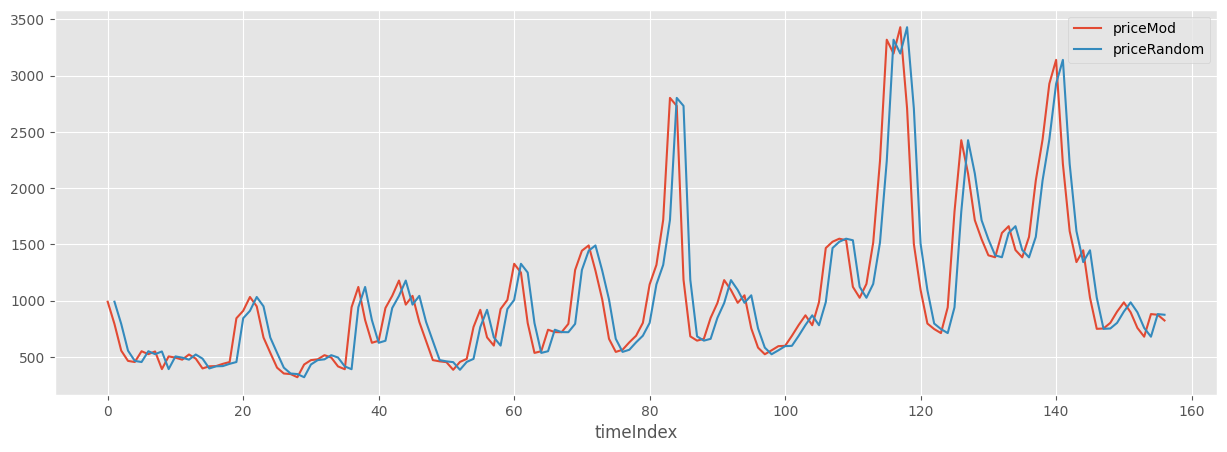

In [44]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod","priceRandom"]);

In [45]:
# Calculamos el RMSE y almacenamos los resultados
dfBangResults.loc[3,"Model"] = "Random"
dfBangResults.loc[3,"Forecast"] = np.exp(dfBang.priceModLogShift1[-1])
dfBangResults.loc[3,"RMSE"] = RMSE(dfBang.priceRandom, dfBang.priceMod)
dfBangResults.head()

C:\Users\yporq\AppData\Local\Temp\ipykernel_59976\3619795076.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dfBangResults.loc[3,"Forecast"] = np.exp(dfBang.priceModLogShift1[-1])


,Model,Forecast,RMSE
0,Mean,879.77008,661.040324
1,Linear,"[498.8165271009785, 502.458470759112, 506.1270...",564.998113
2,LinearQuantity,1875.237553,555.419677
3,Random,875.0,314.31883


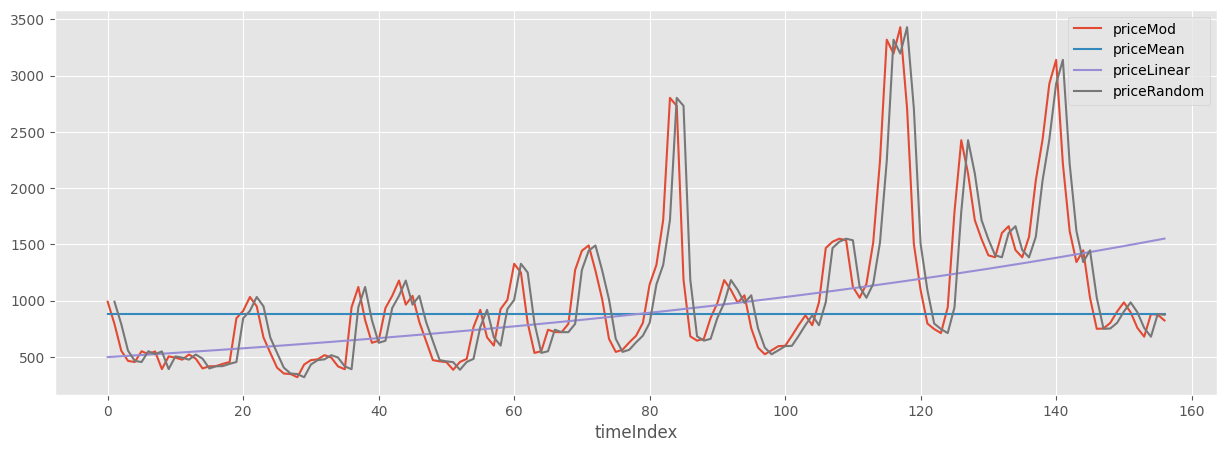

In [46]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", "priceLinear", "priceRandom"]);

## BASE para el ANÁLISIS de las SERIES de TIEMPO

La mayoría de los modelos de series de tiempo funcionan bajo el supuesto de que la serie temporal es estacionaria. Intuitivamente, podemos ver que si una serie de tiempo tiene un comportamiento particular a lo largo del tiempo, existe una gran probabilidad de que siga igual en el futuro. Además, las herramientas relacionadas con series estacionarias han sido más desarrolladas y son más fáciles de implementar que aquellas relacionadas con series que no lo son.

Los models AR y MA requieren para funcionar que la serie sea estacional. La evolución de estos dos modelos, ARIMA, a diferencia de éstos puede trabajar con series no estacionales. 


**Estacionariedad estadística:** una serie temporal estacionaria es aquella cuyas propiedades estadísticas tales como media, varianza, autocorrelación, etc. son todas constantes a lo largo del tiempo. La mayoría de los métodos de pronóstico estadístico se basan en la suposición de que las series de tiempo pueden ser representadas como estacionarias (es decir, "desestacionalizadas") mediante el uso de transformaciones matemáticas. Una serie estacionaria es relativamente fácil de predecir: ¡simplemente predice que sus propiedades estadísticas serán las mismas en el futuro que en el pasado!

Hay tres criterios básicos para que una serie se clasifique como serie estacionaria:

- La <strong> media </strong> de la serie no debe ser una función del tiempo sino una constante.
<center><img src='https://image.ibb.co/edfijG/Mean_nonstationary.png'></center>

- La <strong>  varianza </strong> de la serie no debe ser una función del tiempo. Esta propiedad se conoce como homocedasticidad y representa que la serie tiene varianza homogénea a lo largo del tiempo.
<center><img src='https://image.ibb.co/n1kurw/Var_nonstationary.png'></center>

- La <strong> covarianza </strong>  del primer término y el término (i + m) no deberían ser una función del tiempo.  
<center><img src='https://image.ibb.co/hNCw4G/Cov_nonstationary.png'></center>

### ¿Cómo hacemos para que una serie de tiempo sea estacionaria?
Hay 3 componentes centrales vinculados con la **no estacionariedad** de la serie de tiempo:
* **Tendencia (T)**: existe una tendencia cuando hay un aumento o una disminución del nivel (de la variable en cuestión) a largo plazo. No tiene que ser lineal. A veces nos referiremos a un cambio en la dirección (punto de inflexión) de la serie cuando la tendencia pasa de ser creciente a decreciente.
* **Estacionalidad (S por seasonality)**: existe un patrón estacional cuando una serie está influenciada por factores estacionales (por ejemplo, el trimestre del año en lo que refiere a vacaciones o zafra; el mes si contemplamos crecimiento de ventas (ligado a Navidad, por ejemplo) o el día de la semana). La estacionalidad es siempre de un período fijo y conocido.
* **Cíclico**: existe un patrón cíclico cuando los datos exhibidos suben y bajan sin respetar el período fijo ligado a la estacionalidad. La duración de estas fluctuaciones suele ser de al menos 2 años. Si estuviésemos analizando el PBI de un país, los ciclos económicos con años de crecimiento seguidos de otros de recesión constituyen un buen ejemplo. Sin embargo, cuando hay poca información o las variaciones cíclicas no son muy pronunciadas, este componente puede quedar subsumido al de la tendencia.

Podemos describir el comportamiento de la serie a partir de un modelo **aditivo**:
$$ y_t = T_t + S_t + E_t \\ $$
donde $ y_t $ son los datos en el período t, $ T_t $ es el componente del ciclo de tendencia en el período 't', $ S_t $ es el componente estacional en el período 't' y $ E_t $ es el componente restante (o irregular o error) en el período 't'.

Alternativamente, un modelo **multiplicativo** se escribiría como

$$ y_t = T_t * S_t * E_t \\ $$
El modelo aditivo es más apropiado si la magnitud de las fluctuaciones estacionales o la variación en torno al ciclo de tendencia no varía con el nivel de la serie temporal. Cuando la variación en el patrón estacional, o la variación alrededor del ciclo de tendencia, parece ser proporcional al nivel de la serie temporal, entonces un modelo multiplicativo es más apropiado. Con series de tiempo económicas, los modelos multiplicativos son comunes.

Una alternativa al uso de un modelo multiplicativo es transformar primero los datos hasta que la variación en la serie parezca estable a lo largo del tiempo y luego usar un modelo aditivo. Cuando se ha utilizado una transformación de registro, como por ejemplo el pasaje a escala logarítmica, esto es equivalente a usar una descomposición multiplicativa por las propiedades de esta transformación:

$$ log y_t = log T_t + log S_t + log E_t \\ $$

## 3) Modelos intermedios y avanzados para pronósticos

## 3.a.i) Media móvil (simple moving average)

Como primer paso para ir más allá de los modelos básicos, podemos emplear un modelo suavizado a partir de la media móvil. El supuesto subyacente reside en que la serie temporal sea localmente estacionaria con una media que varía lentamente. 
Por lo tanto, tomamos un promedio móvil (local) para estimar el valor actual de la media y luego lo usamos como pronóstico para el futuro cercano. Esto se puede considerar como un punto medio entre el modelo de media constante y el Random Walk. La misma estrategia se puede usar para estimar y extrapolar una tendencia local. Un promedio móvil a menudo se denomina versión "suavizada" de la serie original porque el promedio a corto plazo tiene el efecto de suavizar los baches en la serie original. Al ajustar el grado de suavización (el ancho de la media móvil o la cantidad de períodos considerados para dicho cálculo), podemos esperar encontrar algún tipo de equilibrio óptimo entre los dos modelos básicos recién mencionados.

$$ \ hat {y_t} = \ frac {y_ {t-1} + y_ {t-2} + y_ {t-3} + ... + y_ {t-m}} {m} \\ $$

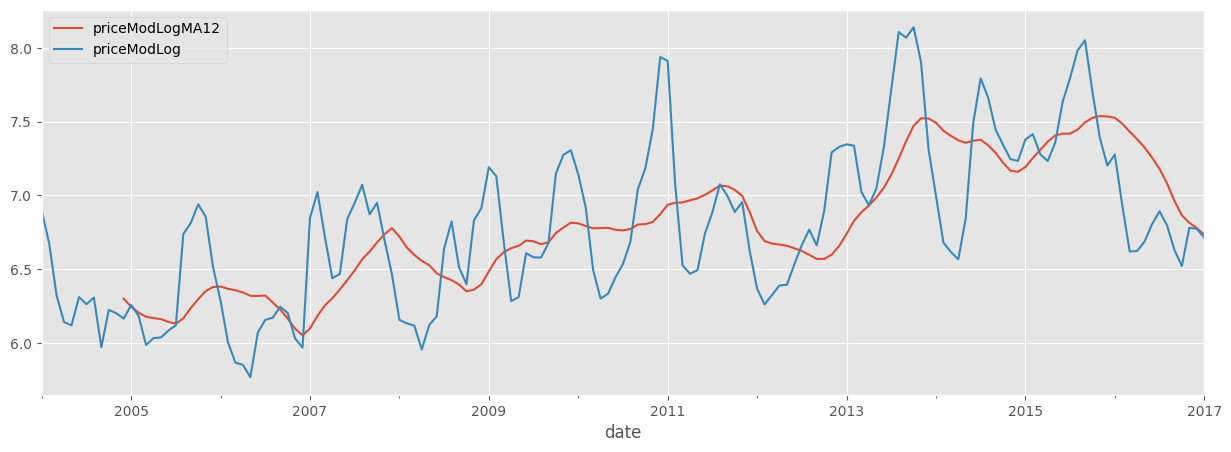

In [47]:
# Calculamos la media móvil de 12 meses para suavizar los valores y ploteamos
dfBang['priceModLogMA12'] = dfBang.priceModLog.rolling(window = 12).mean()
dfBang.plot(kind ="line", y=["priceModLogMA12", "priceModLog"]);

¿Podemos concluir que la media varía a lo largo del tiempo?

In [48]:
dfBang["priceMA12"] = np.exp(dfBang.priceModLogMA12)
dfBang.tail()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,priceModLog,priceMean,timeIndex,priceLinear,priceLinearQuantity,priceModLogShift1,priceModLogDiff,priceRandom,priceModLogMA12,priceMA12
date,,,,,,,,,,,,,,,,,,,,
2016-09,BANGALORE,September,2016,831895,195,1048,758,KT,BANGALORE,2016-09-01,6.630683,879.77008,152,1507.162884,1547.580604,6.799056,-0.168372,897.0,6.963962,1057.816629
2016-10,BANGALORE,October,2016,1620273,216,1103,680,KT,BANGALORE,2016-10-01,6.522093,879.77008,153,1518.166935,1718.113199,6.630683,-0.108591,758.0,6.865553,958.675559
2016-11,BANGALORE,November,2016,1974018,196,1465,881,KT,BANGALORE,2016-11-01,6.781058,879.77008,154,1529.251328,1780.255979,6.522093,0.258965,680.0,6.814895,911.321125
2016-12,BANGALORE,December,2016,947081,192,1315,875,KT,BANGALORE,2016-12-01,6.774224,879.77008,155,1540.416650,1608.375119,6.781058,-0.006834,881.0,6.779192,879.358112
2017-01,BANGALORE,January,2017,363991,193,1097,824,KT,BANGALORE,2017-01-01,6.714171,879.77008,156,1551.663492,1406.449037,6.774224,-0.060053,875.0,6.732212,839.000711


In [60]:
# Incorporamos estimaciones y resultados a nuestro DF
dfBangResults.loc[4,"Model"] = "Moving Average 12"
dfBangResults.loc[4,"Forecast"] = np.exp(dfBang.priceModLog.tail(12).mean())
dfBangResults.loc[4,"RMSE"] = RMSE(dfBang.priceMA12, dfBang.priceMod)

dfBang.priceModLog.tail(12).mean()
dfBangResults.head()

,Model,Forecast,RMSE
0,Mean,879.77008,661.040324
1,Linear,"[498.8165271009785, 502.458470759112, 506.1270...",564.998113
2,LinearQuantity,1875.237553,555.419677
3,Random,875.0,314.31883
4,Moving Average 12,839.000711,518.020684


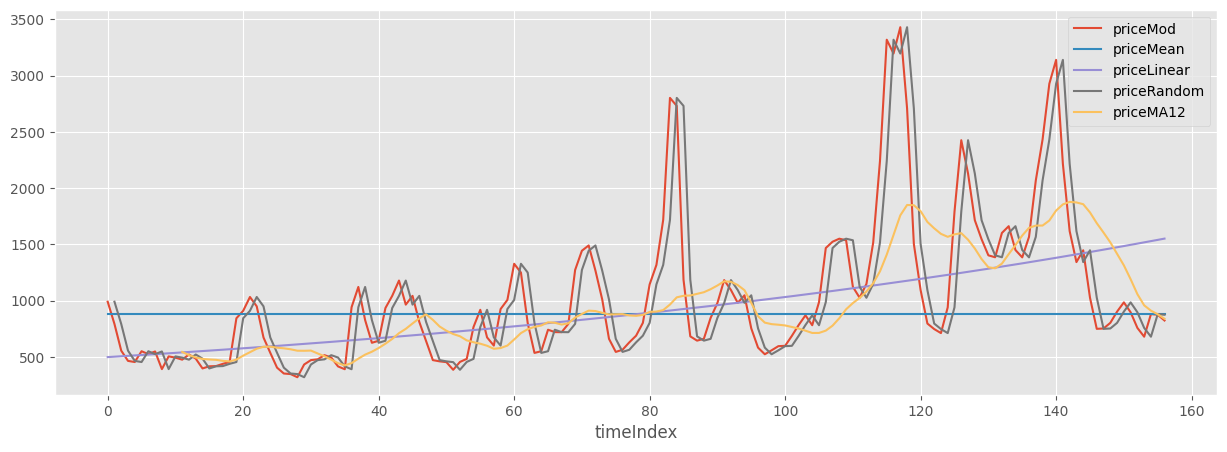

In [50]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", "priceLinear",
                                             "priceRandom", "priceMA12"]);

En ambos casos, podemos rechazar la hipótesis nula y, por lo tanto, considerar la serie como estacionaria.

## 3.b.ii) Modelo ARIMA

El modelo ARIMA sin estacionalidad surge por la combinación de:
* un modelo Auto-Regresivo (AR, p), basado en la diferenciación o rezago de la serie y
* un modelo de media móvil (MA por moving average, q).

Su denominación es producto de las siglas en inglés: **AutoRegressive Integrated Moving Average** model. "Integrated" (integrado) en este contexto refiere a revertir la diferenciación que mencionamos anteriormente. Veamos un mayor detalle de los dos modelos que componen ARIMA:

### Modelos Auto-Regresivos - AR (p)
En un modelo de autorregresión, pronosticamos la variable de interés usando una combinación lineal de valores pasados de la variable en cuestión. El término autoregresión indica que es una regresión de la variable contra sí misma. Por lo tanto, un modelo de **orden autorregresivo (p)** se puede escribir como:

$$ y_t = c + m_1y_ {t-1} + m_2y_ {t-2} + m_3y_ {t-3} + .. \\ $$
El Random Walk es un modelo AR (1) con $$ m_1 = 1,  c = 0 \\ $$ El Random Walk with drift (derivada) $$ m_1 = 1,  c \ != 0 \\ $$

Normalmente restringimos los modelos autorregresivos a datos estacionarios, también pueden ser necesarias algunas condiciones sobre los valores de los parámetros. Para un modelo AR (1): -1.

### Modelo de media móvil - MA (q)
En lugar de utilizar valores pasados de la variable a pronosticar mediante una regresión, un modelo de media móvil usa errores de pronóstico anteriores en un modelo similar a una regresión.

$$ y_t = c + e_t + l_1 e_ {t-1} + l_2 e_ {t-2} + ... + l_q e_ {t-q} \\ $$
donde e es ruido blanco. Nos referimos a esto como un modelo MA **(q)**, donde q representa la **cantidad de rezagos** considerados en el modelo. Por supuesto, no observamos los valores de e (t), por lo que no es realmente regresión en el sentido habitual.

Veamos que cada valor de y (t) se puede considerar como una media móvil ponderada de los últimos errores de pronóstico. Sin embargo, los modelos basados en la media móvil no deben confundirse con el suavizado del promedio móvil. Se usa un modelo de promedio móvil para pronosticar valores futuros, mientras que el suavizado promedio móvil se usa para estimar el ciclo de tendencia de valores pasados.

### Modelo ARIMA 

El modelo completo se puede escribir como: 
* **Número de términos AR (autorregresivos) (p)**: los términos AR son solo rezagos de la variable dependiente. Por ejemplo, si p es 5, los predictores para y (t) serán y (t-1) ... .y (t-5).
* **Número de términos MA (promedio móvil) (q)**: los términos MA son errores de pronóstico rezagados en la ecuación de predicción. Por ejemplo, si q es 5, los predictores para y (t) serán e (t-1) ... .e (t-5) donde e (i) es la diferencia entre el promedio móvil en el valor instantáneo y real.
* **Número de diferencias (d)**: son las diferencias no estacionales que necesitamos para la estacionariedad, es decir, en este caso tomamos la diferencia de primer orden. Entonces, o podemos pasar esa variable y poner d = 0 o pasar la variable original y poner d = 1. Ambos generarán los mismos resultados.

Una preocupación importante aquí es cómo determinar el valor de 'p' y 'q'. Usamos dos vías para determinar estos parámetros, veamos:

* **Función de autocorrelación (ACF)**: es una medida de la correlación entre la serie y su rezago, también se conoce como la función de autocorrelación total. Por ejemplo, en el desfasaje 5, ACF compararía series en el instante instante 't1' ... 't2' con series en el instante 't1-5' ... 't2-5', donde t1-5 y t2 puntos finales).
* **Función de autocorrelación parcial (PACF)**: mide la correlación entre la serie y su rezago después de eliminar las variaciones ya explicadas por las comparaciones intermedias. Por ejemplo, en el desfasaje 5, comprueba la correlación tras eliminar los efectos ya explicados por los rezagos 1 a 4.

En el modelo MA, el ruido (shock) se desvanece rápidamente con el tiempo. En sentido opuesto, el modelo AR tiene un efecto muy duradero del shock. De ahí que, mientras el primero se enfoca en períodos cortos de tiempo, el segundo prioriza el más largo plazo.

In [51]:
ts = dfBang.priceModLog
ts_diff = dfBang.priceModLogDiff
ts_diff.dropna(inplace = True)

In [52]:
# Importamos plots ACF y PACF
from statsmodels.tsa.stattools import acf, pacf

In [53]:
lag_acf = acf(ts_diff, nlags=20)
lag_acf

array([ 1.00000000e+00,  4.02282661e-01, -3.85029189e-02, -2.11084696e-01,
       -2.22356733e-01, -2.40834240e-01, -2.10661228e-01, -9.01674519e-02,
       -9.22005747e-02, -6.85085979e-04,  1.36345360e-01,  2.17127409e-01,
        1.55448995e-01,  7.22485930e-03, -2.12187923e-02, -6.99459739e-02,
       -1.70696931e-01, -7.71730621e-02, -3.30335057e-02, -8.93429815e-02,
       -2.08930298e-01])

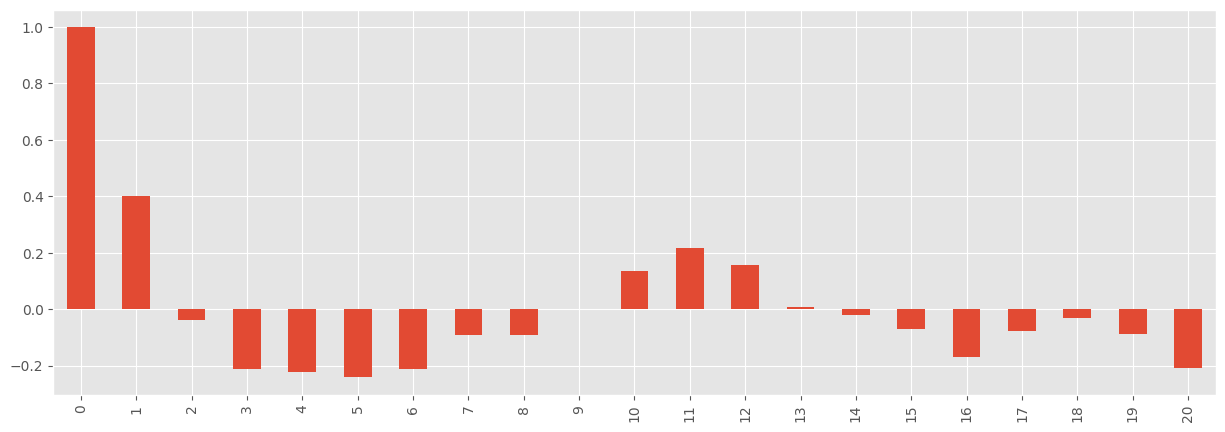

In [54]:
ACF = pd.Series(lag_acf)
ACF.plot(kind = "bar");

In [55]:
lag_pacf = pacf(ts_diff, nlags=20, method='ols');

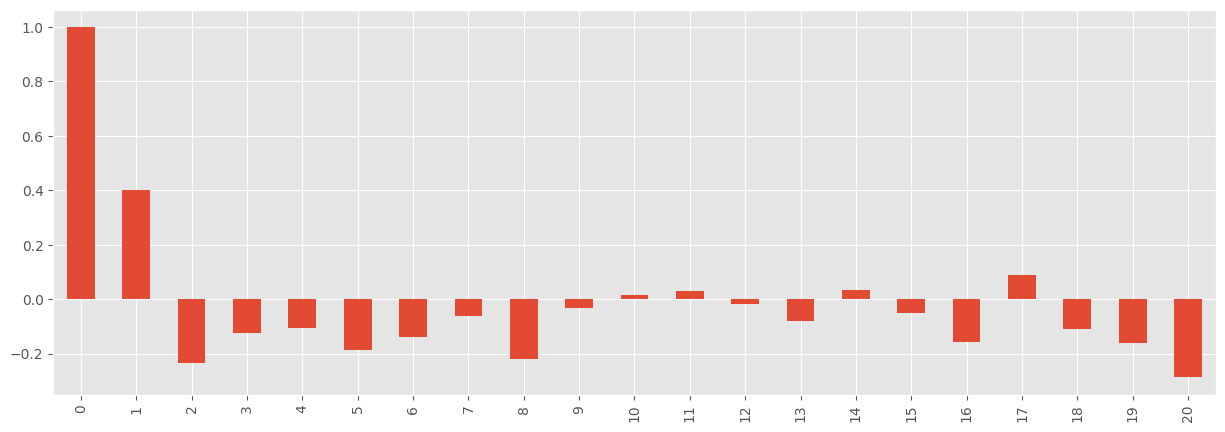

In [56]:
PACF = pd.Series(lag_pacf)
PACF.plot(kind = "bar");

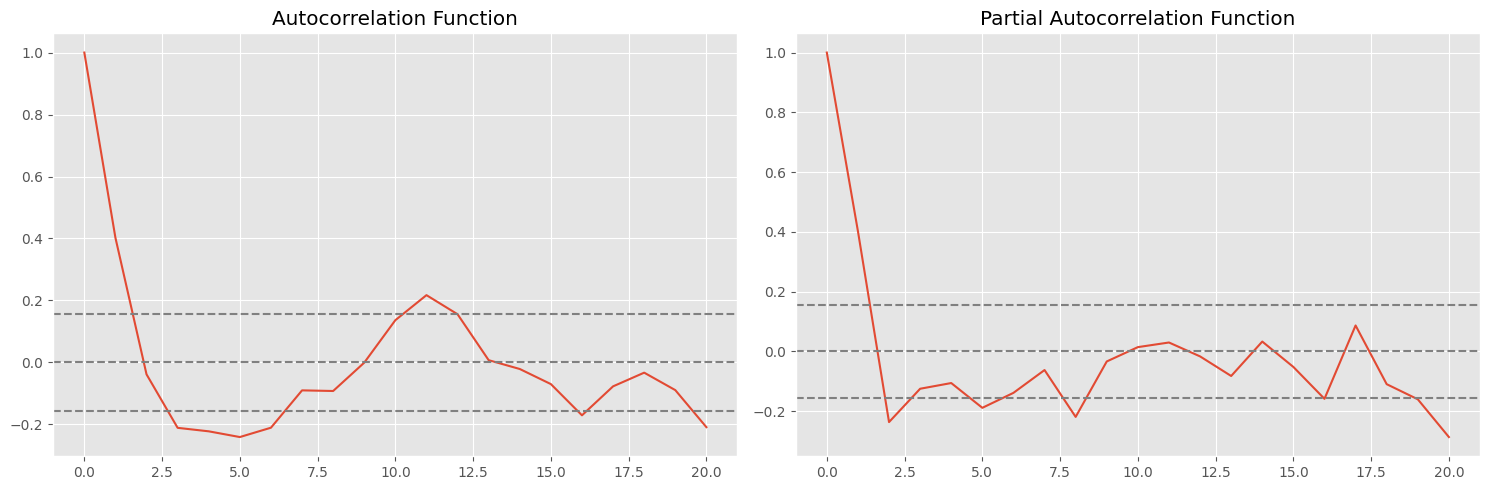

In [57]:
# Veamos qué parámetros son significativamente distintos de cero

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

En el modelo de autocorrelación parcial el primer order es estadísticamente significativo y en los períodos siguientes el shock se licúa y los parámetros son cercanos a 0. Es por esto que vamos a elegir un modelo AR(1) y MA(1). 

### Modelando con ARIMA

In [65]:
from statsmodels.tsa.arima.model import ARIMA

ts.head()

date
2004-01    6.898715
2004-02    6.675823
2004-03    6.320768
2004-04    6.142037
2004-05    6.120297
Freq: M, Name: priceModLog, dtype: float64

In [66]:
# Instancio el modelo con parámetros (p=1,d=0,q=1) según el análisis de ACF y PACF
# En este caso d=0 porque trabajamos directamente con las diferencias
model_AR1MA = ARIMA(ts_diff, order=(1,0,1))

# Fiteo el modelo
results_ARIMA = model_AR1MA.fit()
results_ARIMA.fittedvalues.head()

date
2004-02   -0.001703
2004-03   -0.093610
2004-04   -0.138355
2004-05   -0.040594
2004-06    0.001766
Freq: M, dtype: float64

In [67]:
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:        priceModLogDiff   No. Observations:                  156
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  16.620
Date:                Wed, 26 Feb 2025   AIC                            -25.241
Time:                        14:19:44   BIC                            -13.042
Sample:                    02-29-2004   HQIC                           -20.286
                         - 01-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.028     -0.060      0.952      -0.057       0.054
ar.L1          0.1432      0.207      0.692      0.489      -0.263       0.549
ma.L1          0.3362      0.175      1.916      0.0

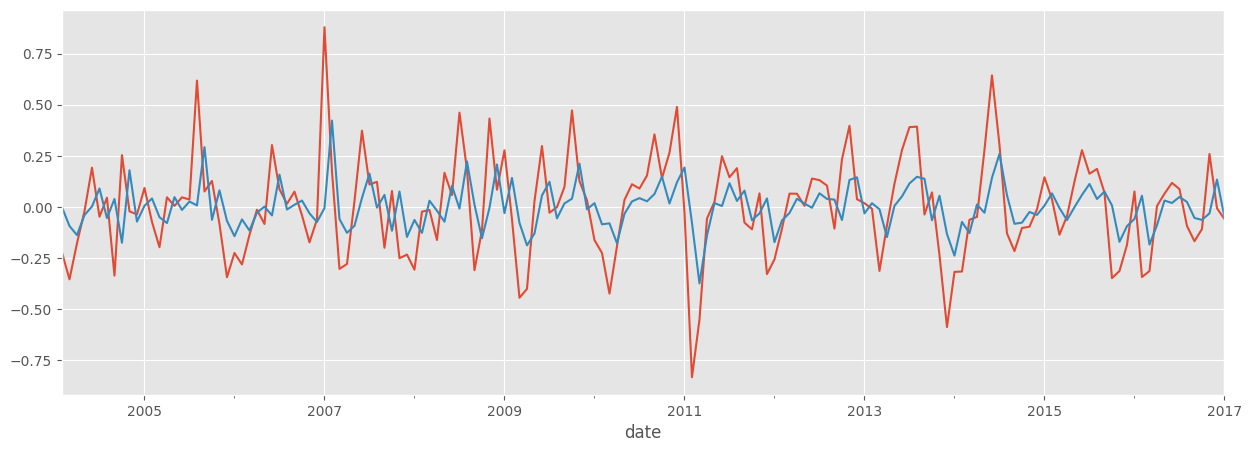

In [68]:
ts_diff.plot()
results_ARIMA.fittedvalues.plot();

In [69]:
ts_diff.sum()

-0.18454400442051622

In [70]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.tail()

date
2016-09   -0.054373
2016-10   -0.063898
2016-11   -0.032035
2016-12    0.133464
2017-01   -0.049610
Freq: M, dtype: float64

In [71]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.tail()

date
2016-09   -0.203607
2016-10   -0.267505
2016-11   -0.299540
2016-12   -0.166075
2017-01   -0.215685
Freq: M, dtype: float64

In [72]:
ts.iloc[0]

6.898714534329988

In [73]:
predictions_ARIMA_log = pd.Series(ts.iloc[0], index=ts.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.tail()

date
2016-09    6.695108
2016-10    6.631210
2016-11    6.599175
2016-12    6.732639
2017-01    6.683029
Freq: M, dtype: float64

In [74]:
# Guardamos nuestros resultados
dfBang['priceARIMA'] = np.exp(predictions_ARIMA_log)

In [75]:
# Incorporamos estimaciones y resultados a nuestro DF
dfBangResults.loc[5,"Model"] = "ARIMA"
dfBangResults.loc[5,"Forecast"] = dfBang.priceARIMA[-1]
dfBangResults.loc[5,"RMSE"] = RMSE(dfBang.priceARIMA, dfBang.priceMod)

C:\Users\yporq\AppData\Local\Temp\ipykernel_59976\1467155173.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dfBangResults.loc[5,"Forecast"] = dfBang.priceARIMA[-1]


In [76]:
dfBangResults.head(10)

,Model,Forecast,RMSE
0,Mean,879.77008,661.040324
1,Linear,"[498.8165271009785, 502.458470759112, 506.1270...",564.998113
2,LinearQuantity,1875.237553,555.419677
3,Random,875.0,314.31883
4,Moving Average 12,839.000711,518.020684
5,ARIMA,798.735028,524.985505


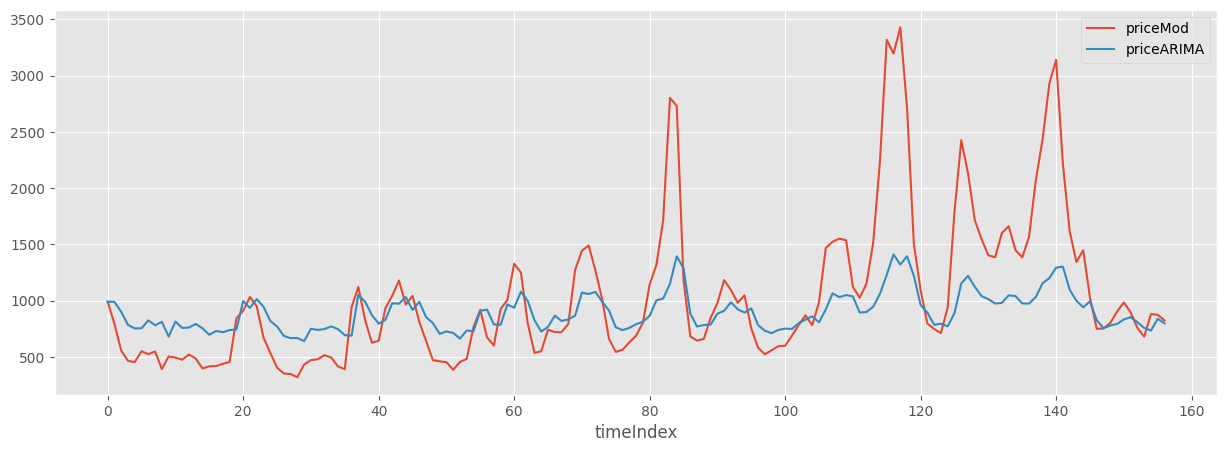

In [77]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceARIMA"]);

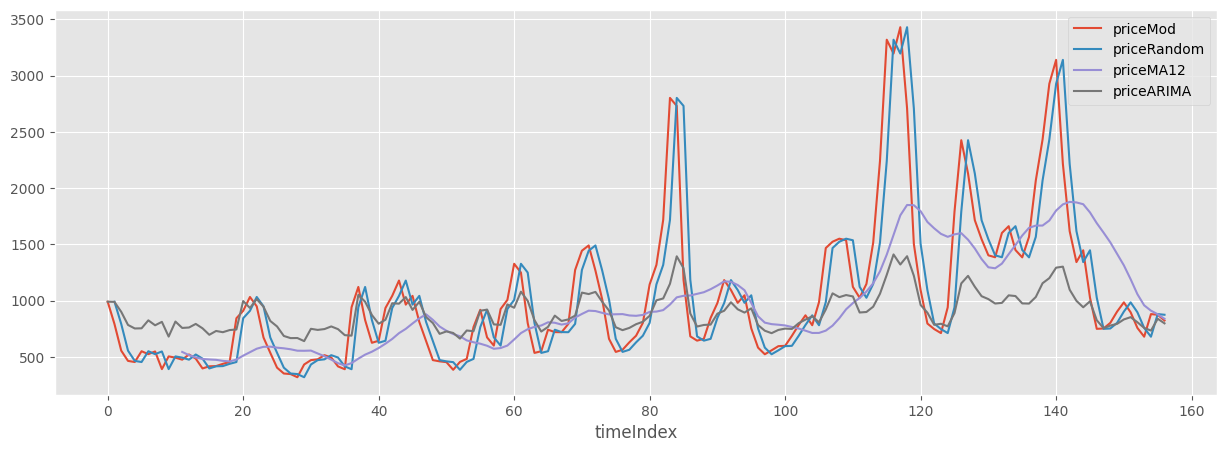

In [78]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceRandom",
                                             "priceMA12", "priceARIMA"]);

* ¿Qué modelo performa mejor? ¿Elegirías alguno? ¿Por qué?